In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch

In [3]:
user_data = pd.read_csv("../data/customers.csv").dropna()
actions_data = pd.read_csv("../data/dataset.csv").dropna().astype(int)
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

## Preprocess user data

In [4]:
user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,Male,No,22,No,Healthcare,4.0
1,817,Female,Yes,38,Yes,Engineer,3.0
2,495,Female,Yes,67,Yes,Engineer,1.0
3,36,Male,Yes,67,Yes,Lawyer,2.0
4,76,Female,Yes,40,Yes,Entertainment,6.0
...,...,...,...,...,...,...,...
315,353,Male,Yes,74,Yes,Lawyer,2.0
316,411,Female,No,30,No,Homemaker,4.0
317,297,Female,No,37,Yes,Artist,2.0
318,186,Female,No,22,No,Marketing,1.0


In [5]:
# Identify the categorical columns
cat_cols = ['gender', 'married', 'graduated', 'profession']

# Convert the categorical columns to numerical using Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    user_data[col] = le.fit_transform(user_data[col])

user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,1,0,22,0,5,4.0
1,817,0,1,38,1,2,3.0
2,495,0,1,67,1,2,1.0
3,36,1,1,67,1,7,2.0
4,76,0,1,40,1,3,6.0
...,...,...,...,...,...,...,...
315,353,1,1,74,1,7,2.0
316,411,0,0,30,0,6,4.0
317,297,0,0,37,1,0,2.0
318,186,0,0,22,0,8,1.0


## Preprocess cars data

In [6]:
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

cars_data["brand"] = cars_data.car_model.apply(lambda a: a.split()[0])
cars_data = cars_data.drop(columns=["car_model", "engine", "car_id"])
cars_data["price"] = cars_data['price'].apply(lambda a: int(a[1:]))

cars_data['used_label'] = cars_data["used_label"].apply(lambda a: 1 if a=="Used" else 0)
# Identify the categorical columns
car_cat_cols = ['exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']

# Convert the categorical columns to numerical using Label Encoding
for col in car_cat_cols:
    le = LabelEncoder()
    cars_data[col] = le.fit_transform(cars_data[col])

cars_data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,mileage,brand
0,1,39,139,11,4,19.0,27.0,3,20,29403.0,28
1,1,49,145,11,3,19.0,24.0,3,2,32929.0,10
2,1,41,62,11,3,15.0,21.0,3,20,23173.0,25
3,1,28,66,83,4,29.0,35.0,3,28,10598.0,13
4,1,49,53,10,4,20.0,27.0,3,20,28137.0,19
...,...,...,...,...,...,...,...,...,...,...,...
399,1,33,46,11,3,18.0,25.0,3,20,43807.0,16
400,0,30,163,57,2,34.0,30.0,5,28,41944.0,28
401,1,35,11,11,2,22.0,29.0,3,24,49386.0,5
402,1,35,168,49,3,16.0,22.0,3,9,115795.0,6


## Preprocess actions data

In [7]:
actions_data = actions_data.rename(columns = {"item_id":"car_id"})

In [8]:
actions_pivot_table = pd.pivot_table(actions_data.sort_values(by="car_id"), values='interaction', index='user_id', columns='car_id').fillna(0)

In [9]:
actions_data.car_id.nunique()

109

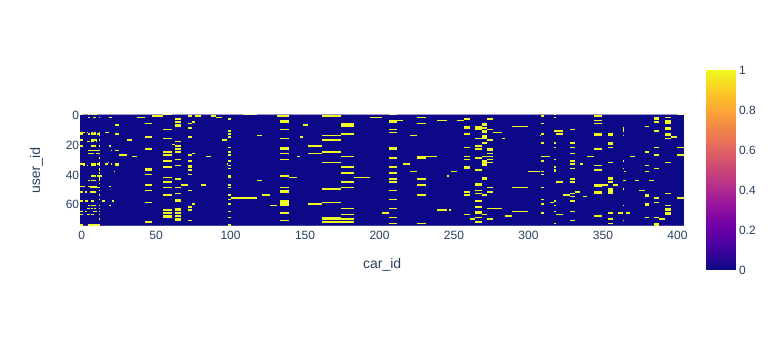

In [10]:
px.imshow(actions_pivot_table)

In [11]:
actions_data = pd.melt(actions_pivot_table.reset_index(), id_vars='user_id', value_vars=actions_pivot_table.columns).rename(columns={"value":"interaction"})

In [12]:
actions_data.interaction.unique()

array([1, 0])

In [13]:
actions_data

,user_id,car_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


In [14]:
actions_data.interaction = actions_data.interaction.apply(lambda a: 1 if a > 0.5 else 0)

In [15]:
actions_data

,user_id,car_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


In [16]:
new_actions_pivot_table = pd.pivot_table(actions_data.sort_values(by="car_id"), values='interaction', index='user_id', columns='car_id').fillna(0)

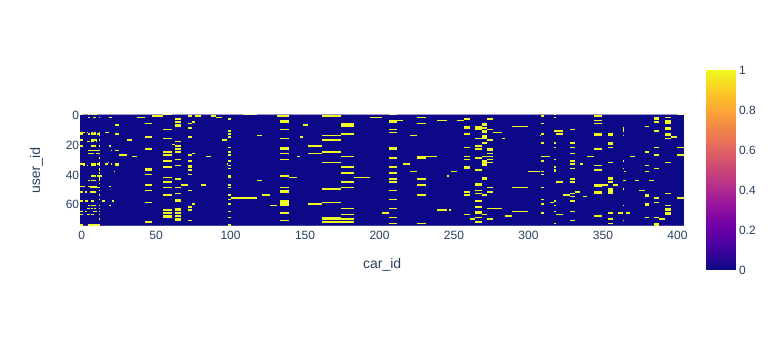

In [17]:
px.imshow(new_actions_pivot_table)

## CatBoost inputs

1. собираю фичи топ n понравившихся авто
2. конкатенирую фичи понравившихся авто с таргет авто
3. делаю бинарную классификацию 

In [18]:
N_POSITIVE = 5

In [19]:
column_names = []
cat_columns = ['used_label', 'exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']
cat_features = []

for index in range(N_POSITIVE):
    for column in cars_data.columns:
        column_names.append(f"car_{index}_{column}")
        
for column in cars_data.columns:
    column_names.append(f"target_{column}")

for column in column_names:
    for c_column in cat_columns:
        if c_column in column:
            cat_features.append(column)
        
dataset = pd.DataFrame(columns=column_names + ["interaction"])

for user_id in actions_data.user_id.unique():
    for target_car_id in actions_data.car_id.unique():
        # len(cars_data.columns) * (N_POSITIVE + 1))
        matrix_features = []
        features = []
        current_positive_samples = actions_data.query(f"user_id == {user_id}").query(f"car_id != {target_car_id}").query("interaction == 1")
        # print()
        if len(current_positive_samples) < N_POSITIVE: continue

        for car_id in current_positive_samples.sample(N_POSITIVE).car_id.to_list():
            matrix_features.append(cars_data.iloc[car_id].to_list())
        matrix_features.append(cars_data.iloc[target_car_id].to_list())
        matrix_features.append(int(actions_data.loc[actions_data.car_id == target_car_id].query(f"user_id == {user_id}").interaction))
        
        for item in matrix_features:
            if isinstance(item, list):
                for elem in item:
                    features.append(elem)
            else:
                features.append(item)
        # print(features)
        dataset = pd.concat([dataset, pd.DataFrame.from_records([dict(zip(dataset.columns, features))])])

# dataset = dataset.astype(int)

In [20]:
dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,1.0,35.0,168.0,49.0,3.0,16.0,22.0,3.0,9.0,115795.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,62.0,11.0,3.0,15.0,21.0,3.0,20.0,23173.0,25.0,0
0,1.0,18.0,139.0,11.0,3.0,14.0,19.0,0.0,9.0,110111.0,...,66.0,83.0,4.0,29.0,35.0,3.0,28.0,10598.0,13.0,0
0,1.0,23.0,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,...,53.0,10.0,4.0,20.0,27.0,3.0,20.0,28137.0,19.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,16.0,66.0,11.0,5.0,19.0,28.0,3.0,9.0,48605.0,...,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,17.0,1
0,1.0,39.0,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,...,11.0,11.0,2.0,21.0,28.0,3.0,24.0,10769.0,22.0,0
0,1.0,39.0,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,...,56.0,35.0,2.0,19.0,26.0,3.0,20.0,22492.0,10.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,90.0,25.0,4.0,26.0,33.0,3.0,28.0,23320.0,23.0,0


In [21]:
dataset.shape

(6931, 67)

In [22]:
dataset.interaction.value_counts()

0    6438
1     493
Name: interaction, dtype: int64

In [23]:
dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,1.0,35.0,168.0,49.0,3.0,16.0,22.0,3.0,9.0,115795.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,62.0,11.0,3.0,15.0,21.0,3.0,20.0,23173.0,25.0,0
0,1.0,18.0,139.0,11.0,3.0,14.0,19.0,0.0,9.0,110111.0,...,66.0,83.0,4.0,29.0,35.0,3.0,28.0,10598.0,13.0,0
0,1.0,23.0,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,...,53.0,10.0,4.0,20.0,27.0,3.0,20.0,28137.0,19.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,16.0,66.0,11.0,5.0,19.0,28.0,3.0,9.0,48605.0,...,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,17.0,1
0,1.0,39.0,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,...,11.0,11.0,2.0,21.0,28.0,3.0,24.0,10769.0,22.0,0
0,1.0,39.0,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,...,56.0,35.0,2.0,19.0,26.0,3.0,20.0,22492.0,10.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,90.0,25.0,4.0,26.0,33.0,3.0,28.0,23320.0,23.0,0


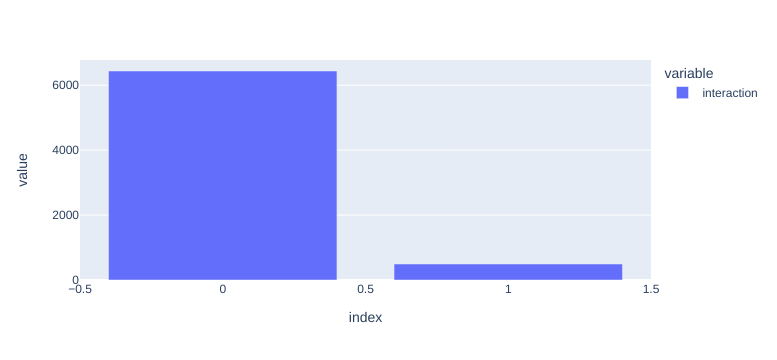

In [24]:
px.bar(dataset.interaction.value_counts())

In [25]:
balanced_dataset = pd.concat([dataset.loc[dataset.interaction == 1], dataset.loc[dataset.interaction == 0].sample(int(dataset.interaction.value_counts()[1] * 1))])

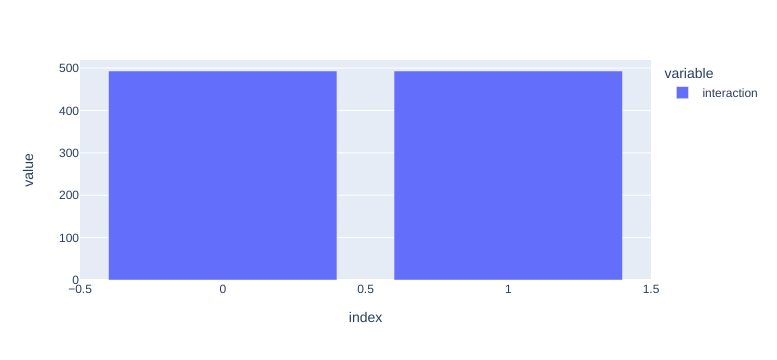

In [26]:
px.bar(balanced_dataset.interaction.value_counts())

In [27]:
balanced_dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,1.0,35.0,168.0,49.0,3.0,16.0,22.0,3.0,9.0,115795.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,22.0,1
0,1.0,23.0,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,...,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,8.0,1
0,1.0,5.0,165.0,76.0,4.0,23.0,23.0,3.0,27.0,204440.0,...,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,44.0,131.0,8.0,2.0,19.0,26.0,3.0,24.0,14445.0,...,36.0,76.0,2.0,17.0,22.0,3.0,4.0,114708.0,19.0,0
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,180.0,83.0,2.0,19.0,26.0,3.0,24.0,15002.0,13.0,0
0,1.0,122.0,173.0,81.0,2.0,80.0,77.0,2.0,0.0,29918.0,...,40.0,11.0,2.0,27.0,33.0,3.0,28.0,70778.0,26.0,0
0,1.0,20.0,158.0,83.0,5.0,20.0,29.0,3.0,15.0,102893.0,...,11.0,11.0,2.0,19.0,24.0,3.0,20.0,37979.0,24.0,0


In [28]:
from sklearn.model_selection import train_test_split
# Split into training and validation sets
train_df, val_df = train_test_split(balanced_dataset.astype(int), test_size=0.2, random_state=42)
X_train, y_train = train_df.drop(columns=['interaction']), train_df[["interaction"]]

# Split into validation and test sets
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42)

X_val, y_val = val_df.drop(columns=['interaction']), val_df[["interaction"]]
X_test, y_test = test_df.drop(columns=['interaction']), test_df[["interaction"]]

## Linear Layers Stack

In [29]:
def normalize(x):
    x_normed = x / x.max(0, keepdims=True)[0]
    return x_normed

In [30]:
# Define the neural network
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(66, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        # x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

# Instantiate the neural network
net = BinaryClassification()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Load the dataset

X_test_tensor = normalize(torch.from_numpy(X_val.values))
y_test_tensor = torch.from_numpy(np.array(y_val)).float()

X_train_tensor = normalize(torch.from_numpy(np.array(X_train)))
y_train_tensor = torch.from_numpy(np.array(y_train)).float()

epochs = 250
# Train the neural network
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = torch.sigmoid(net(X_train_tensor))
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    net.eval()

    train_accuracy = accuracy_score(
            y_train_tensor.flatten().int().tolist(), 
            [int(x.item() > 0.5) for x in torch.sigmoid(net(X_train_tensor))]
        )
    
    test_accurracy = accuracy_score(
        y_test_tensor.flatten().int().tolist(), 
        [int(x.item() > 0.5) for x in torch.sigmoid(net(X_test_tensor))]
        )
    
    net.train()
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print('Epoch [%d/%d], Loss: %.4f train_accuracy: %.4f test_accurracy: %.4f' % (epoch+1, epochs, loss.item(), train_accuracy, test_accurracy))


Epoch [10/250], Loss: 0.6128 train_accuracy: 0.6168 test_accurracy: 0.5823
Epoch [20/250], Loss: 0.5331 train_accuracy: 0.6624 test_accurracy: 0.5506
Epoch [30/250], Loss: 0.4536 train_accuracy: 0.6739 test_accurracy: 0.5506
Epoch [40/250], Loss: 0.3763 train_accuracy: 0.7195 test_accurracy: 0.5633
Epoch [50/250], Loss: 0.3019 train_accuracy: 0.8211 test_accurracy: 0.5380
Epoch [60/250], Loss: 0.2313 train_accuracy: 0.8959 test_accurracy: 0.5633
Epoch [70/250], Loss: 0.1737 train_accuracy: 0.9492 test_accurracy: 0.5886
Epoch [80/250], Loss: 0.1202 train_accuracy: 0.9797 test_accurracy: 0.5506
Epoch [90/250], Loss: 0.0816 train_accuracy: 0.9886 test_accurracy: 0.5696
Epoch [100/250], Loss: 0.0569 train_accuracy: 0.9987 test_accurracy: 0.5759
Epoch [110/250], Loss: 0.0397 train_accuracy: 1.0000 test_accurracy: 0.5696
Epoch [120/250], Loss: 0.0279 train_accuracy: 1.0000 test_accurracy: 0.5633
Epoch [130/250], Loss: 0.0211 train_accuracy: 1.0000 test_accurracy: 0.5506
Epoch [140/250], Loss

In [31]:
from sklearn.metrics import accuracy_score

net.eval()

accuracy_score(
    y_test_tensor.flatten().int().tolist(), 
    [int(x.item() > 0.6) for x in torch.sigmoid(net(X_test_tensor))]
    )

0.5506329113924051

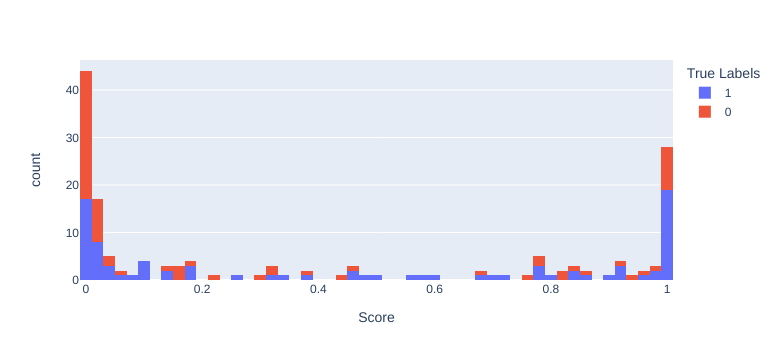

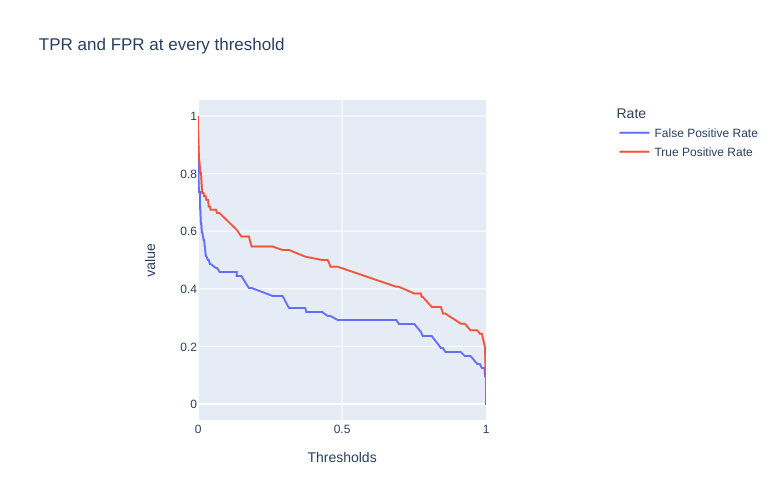

In [32]:
from sklearn import metrics
y_pred_proba = torch.sigmoid(net(X_test_tensor)).flatten().tolist()
fpr, tpr, thresholds = metrics.roc_curve(y_test_tensor.flatten().int().tolist(), y_pred_proba)

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=y_pred_proba, color=y_test_tensor.flatten().int().tolist(), nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

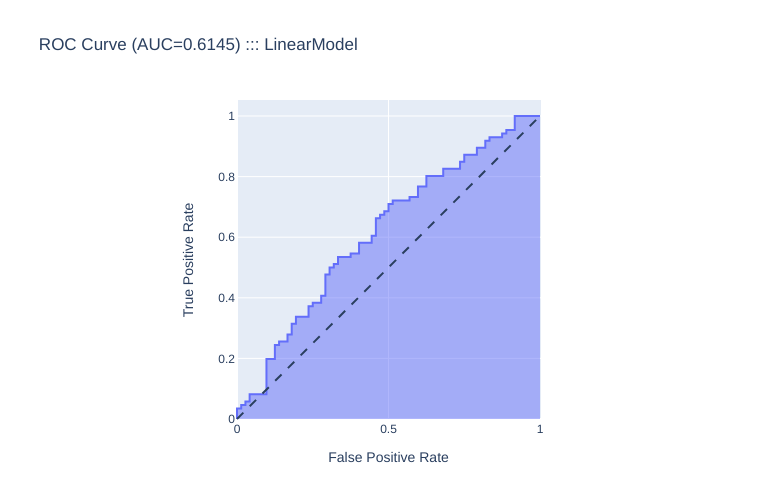

In [35]:
from sklearn.metrics import auc
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f}) ::: LinearModel',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()